In [1]:
#!/usr/bin/env python
# coding: utf-8

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda
from julianToNormal import jd_to_date

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print('how many GPUs? = ',torch.cuda.device_count())

False
how many GPUs? =  0


In [2]:
lat = 14.549077
long = -75.015763
# lat = 0
# long = 0
time = 2455927.5
data = {
    'Latitude': [lat for i in range(1000)],
    'Longitude': [long for i in range(1000)],
    'Julian_Time': [time for i in range(1000)],
    'Depth': [i for i in range(1000)]
}
df = pd.DataFrame(data)

In [3]:
# Training Data Mu and Std
df_mu = pd.read_csv("mu.csv").squeeze()
df_std = pd.read_csv("std.csv").squeeze()
temp_train_mu = df_mu.pop("Temperature")
temp_train_std = df_std.pop("Temperature")

# Normalize and clean data
df_normalized = (df - df_mu) / df_std
df_inputs = df_normalized.dropna()

# Convert to numpy arrays
df_inputs_arr = np.array(df_inputs)
model_input_size = df_inputs_arr.shape[1]

# Convert to tensors
model_inputs = torch.from_numpy(np.float32(df_inputs_arr))

# Send tensors to GPU
model_inputs = model_inputs.to(device)

In [4]:
temp_train_std
model_input_size

4

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(model_input_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x


In [6]:
PATH = "OTEC_miniBatchState.pth"
net = Net()
net.load_state_dict(torch.load(PATH))
net.eval()

# Test Model
model_output = net(model_inputs).detach()
model_output.cpu()
# UnNormalizing and undoing log transform
model_output_unstandardized = model_output * temp_train_std 
model_output_remean = model_output_unstandardized + temp_train_mu
model_output_restored = np.exp(model_output_remean.cpu()) # predicted temperature ** OUTPUT

In [42]:
model_output
# len(model_output_restored.numpy())
# len(model_output_restored.tolist())
depthArr = data["Depth"]
tempArr = [item[0] for item in model_output_restored.tolist()]
# arr = np.array([depthArr, tempArr])
# print("Numpy array:")
# print(arr)

# convert numpy array to dataframe
df = pd.DataFrame(list(zip(depthArr, tempArr)), columns =["Depth", "Temperature"])

print("\nPandas DataFrame: ")
df["Depth"][0]


Numpy array:
[[  0.           1.           2.         ... 997.         998.
  999.        ]
 [ 26.42094421  26.37319565  26.32551956 ...   5.38662291   5.38076544
    5.37491417]]

Pandas DataFrame: 


0

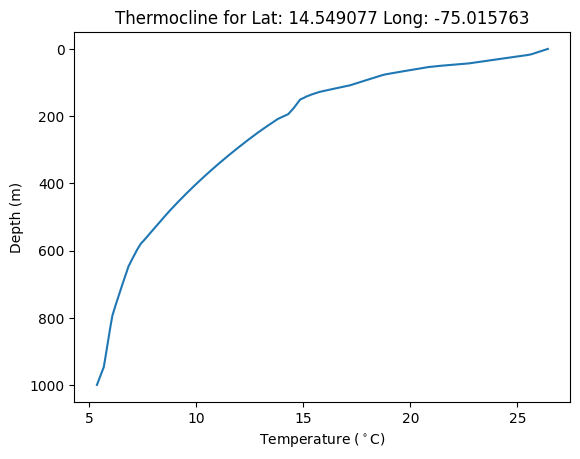

In [8]:
# plt.plot(model_output_restored)
# plt.show()
fig, ax = plt.subplots()
ax.plot(model_output_restored, data["Depth"])  
ax.set_xlabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')
ax.set_title(f'Thermocline for Lat: {lat} Long: {long}')
# ax.xaxis.set_label_position('top') 
# ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.invert_yaxis()

year,month,day=jd_to_date(time)
plt.savefig(f'Thermocline_{lat:,.1f}_{long:,.1f}_{int(month)}-{int(day)}-{str(int(year))[2:]}.png')